# Import

In [1]:
# Клонируем репозитерий stylegan2-ada-pytorch
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git /content/stylegan2-ada-pytorch

Cloning into '/content/stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 131 (delta 0), reused 0 (delta 0), pack-reused 129 (from 2)
Receiving objects: 100% (131/131), 1.13 MiB | 28.24 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [2]:
# Скачиваем модель StyleGAN2
!mkdir -p /content/StyleGAN2
!wget -q https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl -O /content/StyleGAN2/ffhq.pkl # модель обученная на датасете ffhq(лица)

In [3]:
!pip install -q git+https://github.com/openai/CLIP.git # установка CLIP
!pip install -q ninja # утилита для сборки C++/CUDA кода
!pip install -q youtokentome # библиотека от Яндекса для работы с BPE-токенизатором

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 149.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [1]:
import sys
import os
sys.path.append('/content/stylegan2-ada-pytorch')
os.environ['TORCH_CUDA_ARCH_LIST'] = '7.5'

import pickle
import copy

import numpy as np

import clip

import torch
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
from torchvision.transforms import transforms

from PIL import Image
import matplotlib.pyplot as plt

import re

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

RAND = 2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
torch.cuda.manual_seed(RAND)

In [7]:
# Загружаем свое фото
#image =Image.open('/content/kot.jpg')

#plt.figure(figsize=(8,8))
#plt.imshow(image)
#plt.axis('off')
#plt.show()

# Utils

In [4]:
def cleaned_text(text) -> str:
    """
    Простая очистка текста.
    """
    text = str(text) if text is not None else '' # преобразование text в строку, если это не строка
    text = text.lower()
    text = re.sub(r'[^а-яёa-z0-9\s.,*!?:-]', '', text)  # удаление лишних символов (кроме пунктуации)
    text = re.sub(r'\s+', ' ', text).strip()  # удаление лишних пробелов
    text = re.sub(r'^[^\w]+', '', text)  # удаление пунктуации в начале строки
    text = text.strip(' .')  # убирает лишние пробелы и точки в начале и в конце строки
    return text

In [5]:
def preprocessing_text(model,
                       text: str,
                       device: torch.device) -> torch.Tensor:
  """
  Делает простую очистку текста, токенизирует и возвращает эмбеддинги.

  :param model: модель CLIP
  :param text: входной текст
  :param device: устройство для вычислений (CPU или CUDA)

  :return: эмбеддинг текста в пространстве CLIP
  """
  model.eval()
  with torch.no_grad():
    text = cleaned_text(text)
    text_tokenize = clip.tokenize(text).to(device)
    text_features = model.encode_text(text_tokenize)

  return text_features.detach()

In [6]:
def preprocessing_image(model,
                        preprocess_image,
                        image,
                        device: torch.device) -> torch.Tensor:
    """
    Если image - torch.Tensor, то преобразует его в PIL.
    Если image — PIL.Image, используется стандартный CLIP-препроцессор.
    Возвращает эмбеддинг изображения.

    :param model: модель CLIP
    :param preprocess_image: препроцессор модели CLIP для изображения
    :param image: входное изображение
    :param device: устройство для вычислений (CPU или CUDA)

    :return: эмбеддинг изображения в пространстве CLIP
    """
    model.eval()
    if isinstance(image, torch.Tensor):
      # Для torch.Tensor из StyleGAN2 с диапазоном [-1,1]
      transform = transforms.Compose([
          transforms.Lambda(lambda x: ((x + 1) / 2).clamp(0, 1)),
          transforms.Lambda(lambda x: F.interpolate(x,
                                                    size=(224, 224),
                                                    mode='bilinear',
                                                    align_corners=False)),
          transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073),
                               std=(0.26862954, 0.26130258, 0.27577711))])

      image_preproc = transform(image.to(device))

      #image = ((image + 1) / 2).clamp(0, 1) # [-1, 1] → [0, 1]
      #image = (image * 255).to(torch.uint8) # конвертируем в диапазон [0, 255] и в тип uint8
      #image = image.permute(0, 2, 3, 1).cpu().numpy() # меняем формат с CHW → HWC и преобразуем в np.array
      #image = [Image.fromarray(img) for img in image] # cоздаём PIL.Image
      #image_preproc = torch.stack([preprocess(img) for img in image]).to(device)
    else:
      # Для PIL-изображений
      image_preproc = preprocess_image(image).unsqueeze(0).to(device)

    image_features = model.encode_image(image_preproc)

    return image_features

In [7]:
def make_latents(G,
                 RAND: int,
                 device: torch.device):
  """
  Герерирует латенты.

  :param G: генератор, используется для определение размера вектора
  :param RAND: фиксирует генератор случайных чисел
  :param device: устройство для вычислений (CPU или CUDA)

  :return: два латента (latent, latent_sample)
  """
  torch.cuda.manual_seed(RAND)
  latent_sample = torch.randn(4, G.z_dim, device=device)
  latent = torch.randn(2, G.z_dim, device=device)
  return latent_sample, latent

# StyleGN2-ADA

In [19]:
with open('/content/StyleGAN2/ffhq.pkl', 'rb') as f:
  G = pickle.load(f)['G_ema'].to(device)

G_frozen = copy.deepcopy(G) # копия генератора (замороженный)

In [ ]:
latent_sample, latent = make_latents(G,
                                     RAND=RAND,
                                     device=device)

c = None
G.eval()
image_gan = G(latent_sample,
              c,
              truncation_psi=0.7,
              noise_mode='const')

In [ ]:
img = ((image_gan +  1) / 2).clamp(0, 1)  # [-1, 1] → [0, 1]
grid = make_grid(img, nrow=2)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.show()

# CLIP

In [9]:
# Загружаем модель и процессор
model, preprocess = clip.load('ViT-B/32', device=device)

In [ ]:
text_features = preprocessing_text(model, 'woman', device)

In [ ]:
image_features = preprocessing_image(model, preprocess, image_gan, device)

# Train

## Loss

### cosine_dist

In [10]:
def cosine_dist(image_features: torch.Tensor,
                text_features: torch.Tensor) -> torch.Tensor:
 """
 Вычисляет глобальный CLIP-loss (cosine distance).

 :param image_features: вектора изображения в пространстве CLIP
 :param text_features: вектора текста в пространстве CLIP

 :return: косинусное расстояние
 """
 global_loss = 1 - F.cosine_similarity(image_features, text_features, dim=1)
 return global_loss.mean()

### clip_loss

In [11]:
def delta_text(model,
               text_target: str,
               text_source: str,
               device: torch.device) -> torch.Tensor:
  """
  Вычисляет вектор текстового направления между таргетом и текущим стилем.

  :param model: модель CLIP
  :param text_target: текст целевого стиля
  :param text_source: текст исходного стиля
  :param device: устройство для вычислений (CPU или CUDA)

  :return: вектор текстового направления
  """
  emb_delta_text = preprocessing_text(model,
                                      text_target,
                                      device) - preprocessing_text(model,
                                                                   text_source,
                                                                   device)
  return emb_delta_text

In [12]:
def delta_image(model,
                preprocess_image,
                image: torch.Tensor,
                image_frozen: torch.Tensor,
                device: torch.device) -> torch.Tensor:
  """
  Вычисляет вектор визуального направления между изображением до и после fine-tuning.
  :param model: модель CLIP
  :param preprocess_image: препроцессор модели CLIP для изображения
  :param image: изображение из обучаемого генератора
  :param image_frozen: изображение из замороженного генератора
  :param device: устройство для вычислений (CPU или CUDA)

  :return: вектор визуального направления
  """

  emb_delta_image = preprocessing_image(model,
                                        preprocess_image,
                                        image,
                                        device) - preprocessing_image(model,
                                                                      preprocess_image,
                                                                      image_frozen,
                                                                      device)
  return emb_delta_image

In [13]:
def clip_loss(delta_image: torch.Tensor,
              delta_text: torch.Tensor) -> torch.Tensor:
  """
  Вычисляет направленный CLIP-loss.

  :param delta_image: вектор визуального направления
  :param delta_text: вектор текстового направления

  :return: направленный CLIP-loss (скаляр)
  """

  direction_clip_loss = 1 - F.cosine_similarity(delta_image, delta_text, dim=1)
  return direction_clip_loss.mean()

## Train

### cosine_dist

In [20]:
def train_generator(generator,
                    model,
                    preprocess_image,
                    text: str,
                    epochs: int,
                    criterion,
                    device: torch.device,
                    RAND: int=2,
                    batch_size: int=2,
                    sample_size: int=4,
                    lr: float=0.0003,
                    c: torch.Tensor=None):
  """
  Обучает генератор StyleGAN2 для изменения изображений в направлении текста
  с использованием косинусного расстояния в качестве функции потерь.

  Функция выполняет fine-tuning генератора на фиксированном латентном векторе,
  вычисляет эмбеддинги изображения и текста через CLIP и минимизирует
  косинусное расстояние между ними, чтобы стилизовать изображение под заданный текст.

  Каждые 50 эпох сохраняет сгенерированные изображения.
  В конце визуализирует поведение функции потерь.

  :param generator: генератор StyleGAN2, который будет обучаться
  :param model: модель CLIP для получения текстовых и визуальных эмбеддингов
  :param preprocess_image: функция препроцессинга изображений для CLIP
  :param text: целевой текстовый промпт, определяющий желаемый стиль изображения
  :param epochs: количество эпох обучения генератора
  :param criterion: функция потерь, которая принимает текстовые и визуальные эмбеддинги и возвращает скалярный loss
  :param device: устройство для вычислений (CPU или CUDA)
  :param RAND: фиксирует генератор случайных чисел
  :param batch_size: размерность батча для обучения
  :param sample_size: размерность генерируемого сэмпла
  :param lr: скорость обучения для оптимизатора
  :param c: условие для генератора

  :return: None
  """
  loss_lst = []

  torch.cuda.manual_seed(RAND)
  os.makedirs('results', exist_ok=True)

  latent_sample = torch.randn(sample_size, generator.z_dim, device=device)
  latent = torch.randn(batch_size, generator.z_dim, device=device)

  optimizer = torch.optim.AdamW(generator.parameters(), lr=lr)

  generator.train()
  for param in generator.parameters():
    param.requires_grad = True

  for i in tqdm(range(epochs)):
    torch.cuda.empty_cache()
    optimizer.zero_grad()

    image = generator(latent, c, truncation_psi=0.7, noise_mode='const')

    text_features = preprocessing_text(model,
                                       text,
                                       device)
    image_features = preprocessing_image(model,
                                         preprocess,
                                         image,
                                         device)

    loss = criterion(text_features, image_features)
    loss.backward()
    optimizer.step()

    loss_lst.append(loss.item())

    torch.cuda.empty_cache()

    print(f'Эпоха {i + 1}: loss={loss.item():.4f}')

    if i % 50 == 0:
      image_sample = generator(latent_sample,
                               c,
                               truncation_psi=0.7,
                               noise_mode='const')
      img = (image_sample.clamp(-1, 1) + 1) / 2.0  # [-1, 1] → [0, 1]
      grid = make_grid(img, nrow=2)

      save_path = f'results/generated_image_epoch_{i}.jpg'
      save_image(grid, save_path, 'jpeg')

      plt.figure(figsize=(8, 8))
      plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
      plt.axis('off')
      plt.show()

  plt.figure(figsize=(8, 8))
  plt.plot(loss_lst)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('График лосса')
  plt.grid(True)
  plt.show()

  0%|          | 0/301 [00:00<?, ?it/s]

Эпоха 1: loss=0.7988


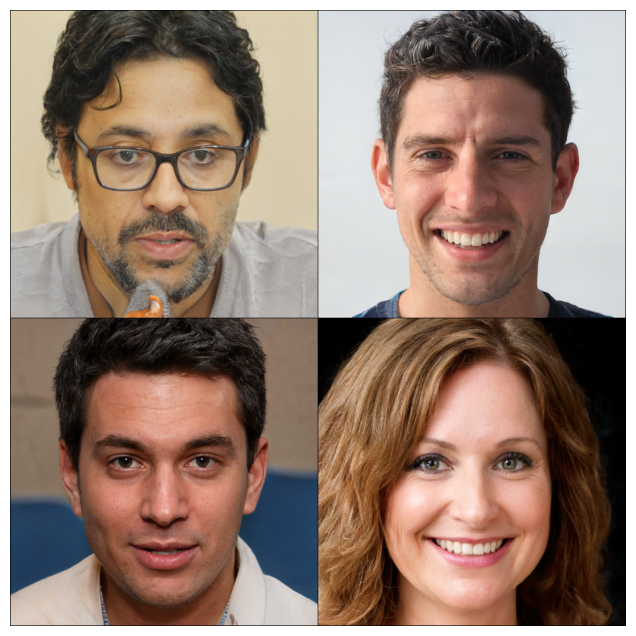

Эпоха 2: loss=0.7803
Эпоха 3: loss=0.7686
Эпоха 4: loss=0.7588
Эпоха 5: loss=0.7480
Эпоха 6: loss=0.7363
Эпоха 7: loss=0.7266
Эпоха 8: loss=0.7192
Эпоха 9: loss=0.7119
Эпоха 10: loss=0.7070
Эпоха 11: loss=0.7017
Эпоха 12: loss=0.6963
Эпоха 13: loss=0.6914
Эпоха 14: loss=0.6875
Эпоха 15: loss=0.6831
Эпоха 16: loss=0.6787
Эпоха 17: loss=0.6748
Эпоха 18: loss=0.6709
Эпоха 19: loss=0.6680
Эпоха 20: loss=0.6650
Эпоха 21: loss=0.6621
Эпоха 22: loss=0.6597
Эпоха 23: loss=0.6572
Эпоха 24: loss=0.6553
Эпоха 25: loss=0.6528
Эпоха 26: loss=0.6509
Эпоха 27: loss=0.6484
Эпоха 28: loss=0.6470
Эпоха 29: loss=0.6455
Эпоха 30: loss=0.6436
Эпоха 31: loss=0.6416
Эпоха 32: loss=0.6396
Эпоха 33: loss=0.6382
Эпоха 34: loss=0.6367
Эпоха 35: loss=0.6348
Эпоха 36: loss=0.6333
Эпоха 37: loss=0.6323
Эпоха 38: loss=0.6309
Эпоха 39: loss=0.6289
Эпоха 40: loss=0.6279
Эпоха 41: loss=0.6260
Эпоха 42: loss=0.6245
Эпоха 43: loss=0.6226
Эпоха 44: loss=0.6211
Эпоха 45: loss=0.6201
Эпоха 46: loss=0.6182
Эпоха 47: loss=0.6

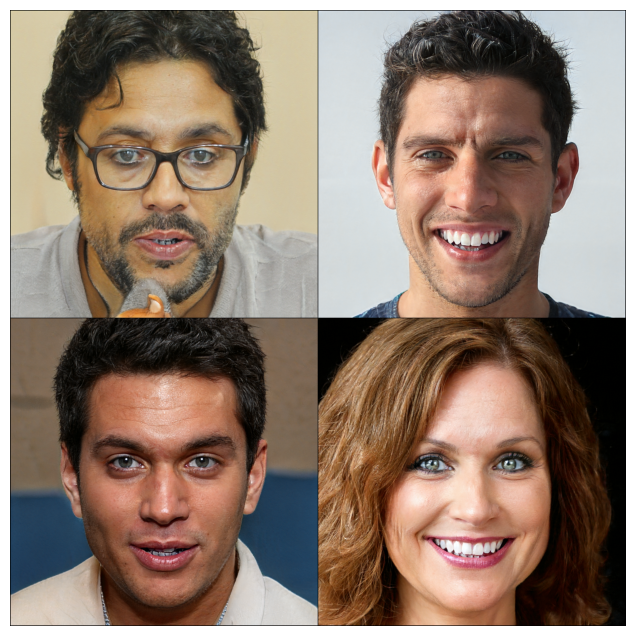

Эпоха 52: loss=0.6089
Эпоха 53: loss=0.6074
Эпоха 54: loss=0.6060
Эпоха 55: loss=0.6045
Эпоха 56: loss=0.6030
Эпоха 57: loss=0.6021
Эпоха 58: loss=0.6006
Эпоха 59: loss=0.5996
Эпоха 60: loss=0.5986
Эпоха 61: loss=0.5972
Эпоха 62: loss=0.5957
Эпоха 63: loss=0.5947
Эпоха 64: loss=0.5938
Эпоха 65: loss=0.5923
Эпоха 66: loss=0.5908
Эпоха 67: loss=0.5898
Эпоха 68: loss=0.5884
Эпоха 69: loss=0.5874
Эпоха 70: loss=0.5864
Эпоха 71: loss=0.5850
Эпоха 72: loss=0.5845
Эпоха 73: loss=0.5830
Эпоха 74: loss=0.5820
Эпоха 75: loss=0.5811
Эпоха 76: loss=0.5801
Эпоха 77: loss=0.5791
Эпоха 78: loss=0.5776
Эпоха 79: loss=0.5762
Эпоха 80: loss=0.5752
Эпоха 81: loss=0.5742
Эпоха 82: loss=0.5732
Эпоха 83: loss=0.5723
Эпоха 84: loss=0.5713
Эпоха 85: loss=0.5703
Эпоха 86: loss=0.5693
Эпоха 87: loss=0.5684
Эпоха 88: loss=0.5679
Эпоха 89: loss=0.5669
Эпоха 90: loss=0.5674
Эпоха 91: loss=0.5674
Эпоха 92: loss=0.5664
Эпоха 93: loss=0.5654
Эпоха 94: loss=0.5640
Эпоха 95: loss=0.5630
Эпоха 96: loss=0.5625
Эпоха 97: 

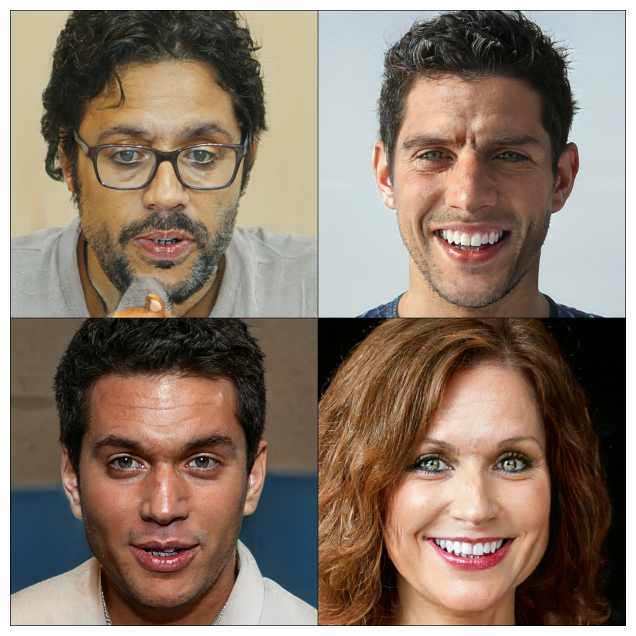

Эпоха 102: loss=0.5581
Эпоха 103: loss=0.5581
Эпоха 104: loss=0.5566
Эпоха 105: loss=0.5557
Эпоха 106: loss=0.5557
Эпоха 107: loss=0.5547
Эпоха 108: loss=0.5542
Эпоха 109: loss=0.5532
Эпоха 110: loss=0.5527
Эпоха 111: loss=0.5518
Эпоха 112: loss=0.5518
Эпоха 113: loss=0.5508
Эпоха 114: loss=0.5503
Эпоха 115: loss=0.5493
Эпоха 116: loss=0.5488
Эпоха 117: loss=0.5483
Эпоха 118: loss=0.5479
Эпоха 119: loss=0.5469
Эпоха 120: loss=0.5469
Эпоха 121: loss=0.5459
Эпоха 122: loss=0.5454
Эпоха 123: loss=0.5449
Эпоха 124: loss=0.5449
Эпоха 125: loss=0.5435
Эпоха 126: loss=0.5430
Эпоха 127: loss=0.5430
Эпоха 128: loss=0.5420
Эпоха 129: loss=0.5420
Эпоха 130: loss=0.5410
Эпоха 131: loss=0.5410
Эпоха 132: loss=0.5415
Эпоха 133: loss=0.5396
Эпоха 134: loss=0.5400
Эпоха 135: loss=0.5391
Эпоха 136: loss=0.5381
Эпоха 137: loss=0.5381
Эпоха 138: loss=0.5371
Эпоха 139: loss=0.5361
Эпоха 140: loss=0.5361
Эпоха 141: loss=0.5352
Эпоха 142: loss=0.5347
Эпоха 143: loss=0.5342
Эпоха 144: loss=0.5342
Эпоха 145: 

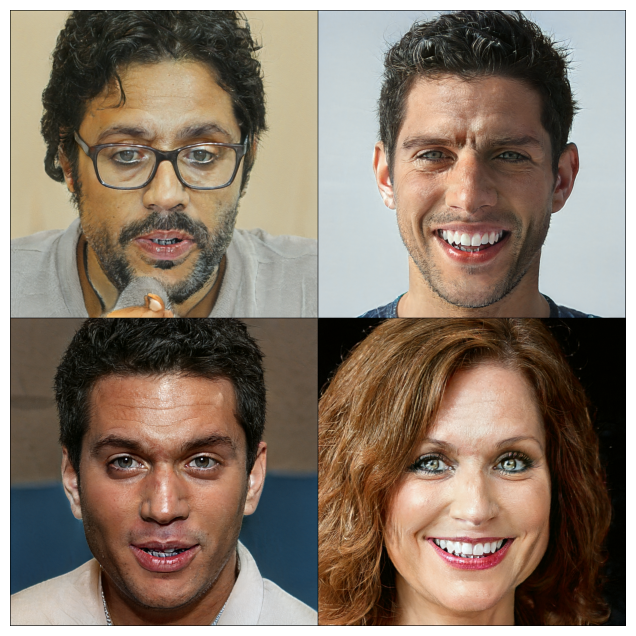

Эпоха 152: loss=0.5298
Эпоха 153: loss=0.5293
Эпоха 154: loss=0.5283
Эпоха 155: loss=0.5283
Эпоха 156: loss=0.5278
Эпоха 157: loss=0.5273
Эпоха 158: loss=0.5269
Эпоха 159: loss=0.5269
Эпоха 160: loss=0.5259
Эпоха 161: loss=0.5254
Эпоха 162: loss=0.5244
Эпоха 163: loss=0.5239
Эпоха 164: loss=0.5234
Эпоха 165: loss=0.5229
Эпоха 166: loss=0.5225
Эпоха 167: loss=0.5220
Эпоха 168: loss=0.5210
Эпоха 169: loss=0.5210
Эпоха 170: loss=0.5200
Эпоха 171: loss=0.5205
Эпоха 172: loss=0.5200
Эпоха 173: loss=0.5195
Эпоха 174: loss=0.5190
Эпоха 175: loss=0.5210
Эпоха 176: loss=0.5200
Эпоха 177: loss=0.5195
Эпоха 178: loss=0.5195
Эпоха 179: loss=0.5200
Эпоха 180: loss=0.5195
Эпоха 181: loss=0.5186
Эпоха 182: loss=0.5186
Эпоха 183: loss=0.5186
Эпоха 184: loss=0.5176
Эпоха 185: loss=0.5166
Эпоха 186: loss=0.5166
Эпоха 187: loss=0.5161
Эпоха 188: loss=0.5156
Эпоха 189: loss=0.5146
Эпоха 190: loss=0.5142
Эпоха 191: loss=0.5137
Эпоха 192: loss=0.5137
Эпоха 193: loss=0.5127
Эпоха 194: loss=0.5127
Эпоха 195: 

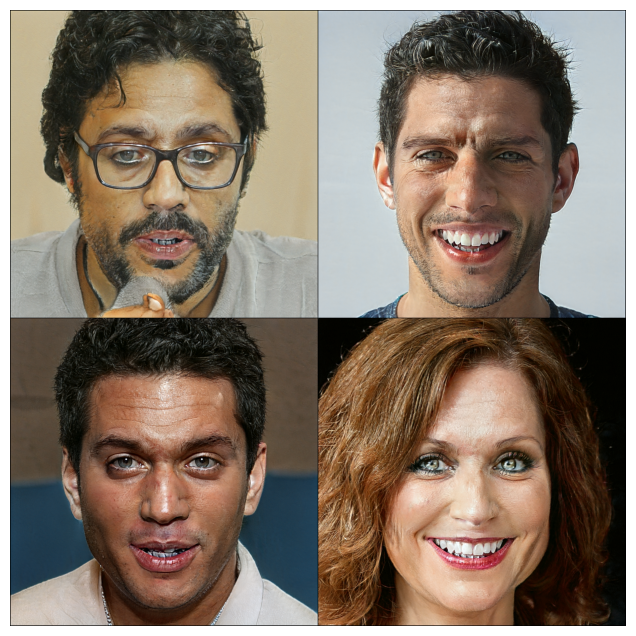

Эпоха 202: loss=0.5083
Эпоха 203: loss=0.5078
Эпоха 204: loss=0.5073
Эпоха 205: loss=0.5068
Эпоха 206: loss=0.5068
Эпоха 207: loss=0.5059
Эпоха 208: loss=0.5059
Эпоха 209: loss=0.5054
Эпоха 210: loss=0.5049
Эпоха 211: loss=0.5044
Эпоха 212: loss=0.5039
Эпоха 213: loss=0.5034
Эпоха 214: loss=0.5034
Эпоха 215: loss=0.5029
Эпоха 216: loss=0.5024
Эпоха 217: loss=0.5020
Эпоха 218: loss=0.5015
Эпоха 219: loss=0.5010
Эпоха 220: loss=0.5005
Эпоха 221: loss=0.5000
Эпоха 222: loss=0.4998
Эпоха 223: loss=0.4990
Эпоха 224: loss=0.4985
Эпоха 225: loss=0.4980
Эпоха 226: loss=0.4978
Эпоха 227: loss=0.4973
Эпоха 228: loss=0.4968
Эпоха 229: loss=0.4961
Эпоха 230: loss=0.4956
Эпоха 231: loss=0.4954
Эпоха 232: loss=0.4951
Эпоха 233: loss=0.4946
Эпоха 234: loss=0.4937
Эпоха 235: loss=0.4934
Эпоха 236: loss=0.4932
Эпоха 237: loss=0.4927
Эпоха 238: loss=0.4939
Эпоха 239: loss=0.4937
Эпоха 240: loss=0.4937
Эпоха 241: loss=0.4927
Эпоха 242: loss=0.4929
Эпоха 243: loss=0.4915
Эпоха 244: loss=0.4917
Эпоха 245: 

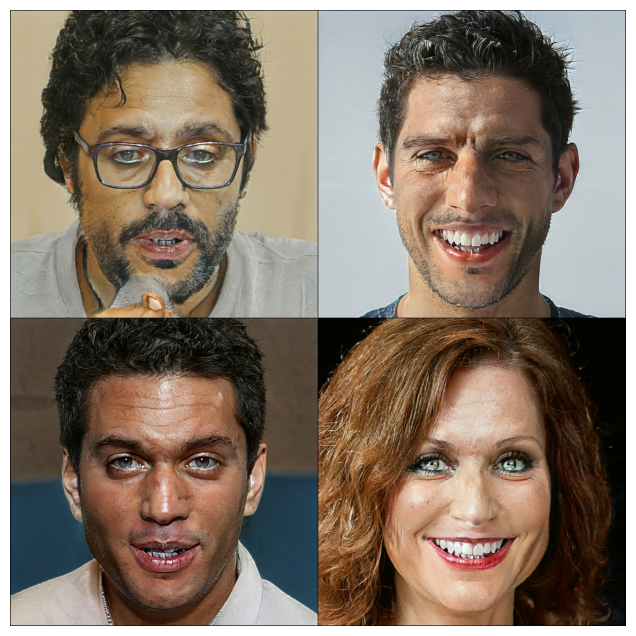

Эпоха 252: loss=0.4871
Эпоха 253: loss=0.4875
Эпоха 254: loss=0.4861
Эпоха 255: loss=0.4849
Эпоха 256: loss=0.4873
Эпоха 257: loss=0.4856
Эпоха 258: loss=0.4841
Эпоха 259: loss=0.4827
Эпоха 260: loss=0.4814
Эпоха 261: loss=0.4814
Эпоха 262: loss=0.4810
Эпоха 263: loss=0.4797
Эпоха 264: loss=0.4790
Эпоха 265: loss=0.4775
Эпоха 266: loss=0.4771
Эпоха 267: loss=0.4761
Эпоха 268: loss=0.4756
Эпоха 269: loss=0.4753
Эпоха 270: loss=0.4744
Эпоха 271: loss=0.4736
Эпоха 272: loss=0.4729
Эпоха 273: loss=0.4722
Эпоха 274: loss=0.4714
Эпоха 275: loss=0.4712
Эпоха 276: loss=0.4702
Эпоха 277: loss=0.4695
Эпоха 278: loss=0.4690
Эпоха 279: loss=0.4683
Эпоха 280: loss=0.4678
Эпоха 281: loss=0.4673
Эпоха 282: loss=0.4673
Эпоха 283: loss=0.4673
Эпоха 284: loss=0.4717
Эпоха 285: loss=0.4702
Эпоха 286: loss=0.4678
Эпоха 287: loss=0.4683
Эпоха 288: loss=0.4688
Эпоха 289: loss=0.4685
Эпоха 290: loss=0.4668
Эпоха 291: loss=0.4663
Эпоха 292: loss=0.4656
Эпоха 293: loss=0.4651
Эпоха 294: loss=0.4644
Эпоха 295: 

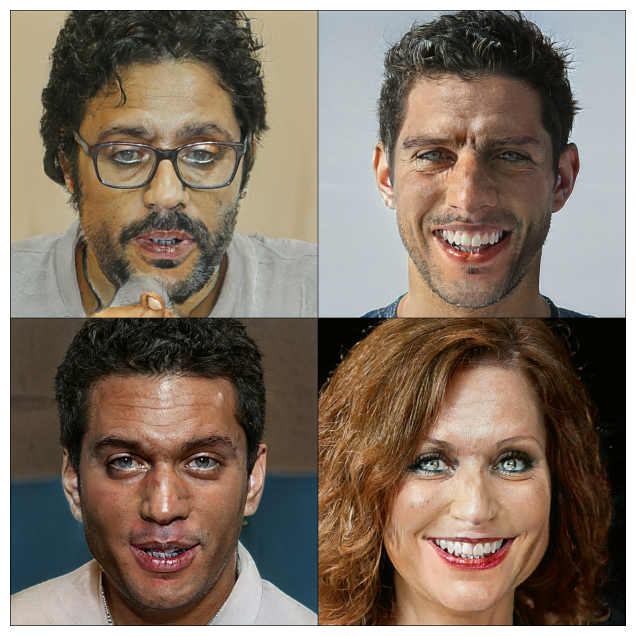

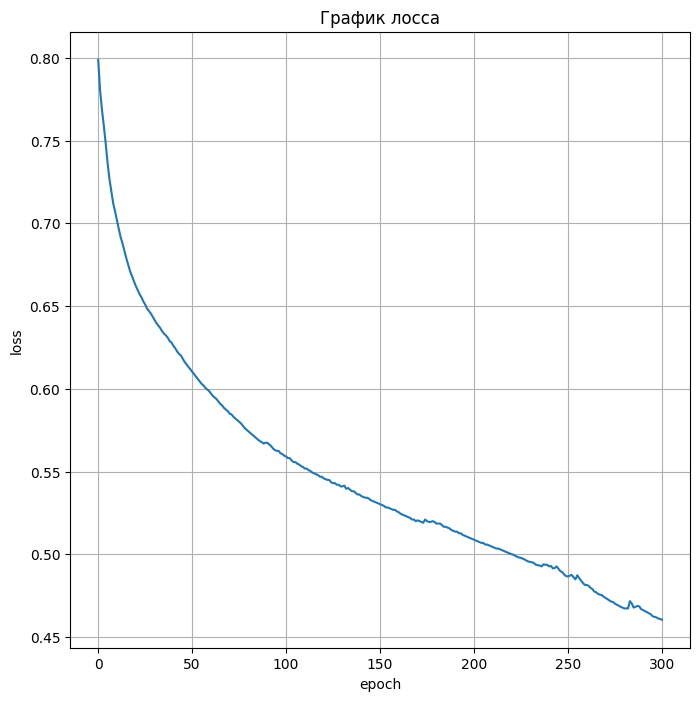

In [19]:
train_generator(generator=G,
                model=model,
                preprocess_image=preprocess,
                text='werewolf',
                epochs=301,
                criterion=cosine_dist,
                device=device,
                RAND=2,
                batch_size=2,
                sample_size=4,
                lr=0.0003,
                c=None)

### clip_loss

In [20]:
def train_generator(generator,
                    generator_frozen,
                    model,
                    preprocess_image,
                    text_source: str,
                    text_target: str,
                    epochs: int,
                    criterion,
                    device: torch.device,
                    RAND: int=2,
                    batch_size: int=2,
                    sample_size: int=4,
                    lr: float=0.002,
                    c: torch.Tensor=None):
  """
  Обучает генератор StyleGAN2 для изменения изображений в направлении текста
  с использованием CLIP-косинусного расстояния в качестве функции потерь.

  Функция выполняет fine-tuning генератора на фиксированном латентном векторе,
  вычисляет векторное направление между изображениями до и после обучения
  и текстовыми эмбеддингами, и минимизирует косинусное расстояние между ними.

  Каждые 50 эпох сохраняет сгенерированные изображения.
  В конце визуализирует график лосса.

  :param generator: генератор StyleGAN2, который будет обучаться
  :param generator_frozen: замороженный генератор, используемый для вычисления delta_image
  :param model: модель CLIP для получения текстовых и визуальных эмбеддингов
  :param preprocess_image: функция препроцессинга изображений для CLIP
  :param text_source: исходный текстовый промпт
  :param text_target: целевой текстовый промпт
  :param epochs: количество эпох обучения генератора
  :param criterion: функция потерь, которая принимает delta_image и delta_text и возвращает скалярный loss
  :param device: устройство для вычислений (CPU или CUDA)
  :param RAND: фиксирует генератор случайных чисел
  :param batch_size: размерность батча для обучения
  :param sample_size: размерность генерируемого сэмпла
  :param lr: скорость обучения для оптимизатора
  :param c: условие для генератора

  :return: None
  """
  loss_lst = []

  os.makedirs('results', exist_ok=True)

  latent_sample = torch.randn(sample_size, generator.z_dim, device=device)
  latent = torch.randn(batch_size, generator.z_dim, device=device)

  optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

  generator.train()
  generator_frozen.eval()
  for param in generator.parameters():
    param.requires_grad = True

  for param in generator_frozen.parameters():
    param.requires_grad = False

  for i in tqdm(range(epochs)):
    optimizer.zero_grad()

    image = generator(latent,
                      c,
                      truncation_psi=0.7,
                      noise_mode='const')
    image_frozen = generator_frozen(latent,
                                    c,
                                    truncation_psi=0.7,
                                    noise_mode='const')

    emb_delta_image = delta_image(model,
                                  preprocess_image,
                                  image,
                                  image_frozen,
                                  device)

    emb_delta_text = delta_text(model,
                                text_target,
                                text_source,
                                device)

    loss = criterion(emb_delta_image,
                     emb_delta_text)

    loss.backward()
    optimizer.step()

    loss_lst.append(loss.item())

    torch.cuda.empty_cache()

    print(f'Эпоха {i + 1}: loss={loss.item():.4f}')

    if i % 50 == 0:
      image_sample = generator(latent_sample,
                               c,
                               truncation_psi=0.7,
                               noise_mode='const')
      img = (image_sample.clamp(-1, 1) + 1) / 2.0  # [-1, 1] → [0, 1]
      grid = make_grid(img, nrow=2)

      save_path = f'results/generated_image_epoch_{i}.jpg'
      save_image(grid, save_path, 'jpeg')

      plt.figure(figsize=(8, 8))
      plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
      plt.axis('off')
      plt.show()

  plt.figure(figsize=(8, 8))
  plt.plot(loss_lst)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('График лосса')
  plt.grid(True)
  plt.show()

  0%|          | 0/301 [00:00<?, ?it/s]

Эпоха 1: loss=0.9985


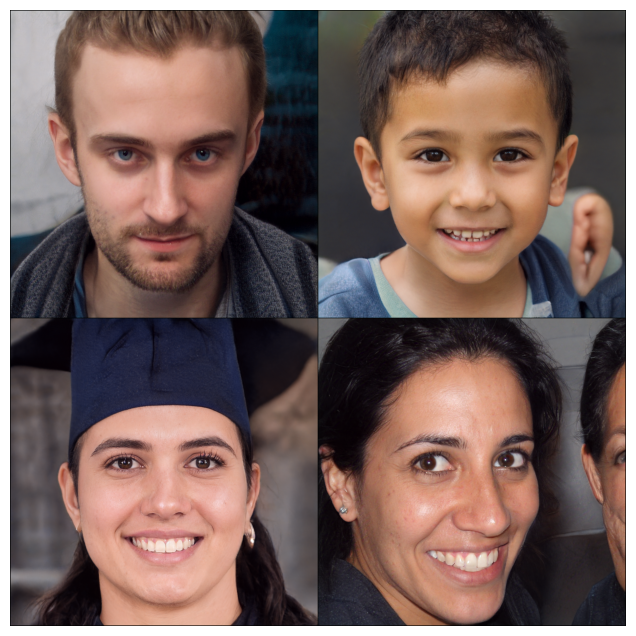

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 8.12 MiB is free. Process 70640 has 14.73 GiB memory in use. Of the allocated memory 14.48 GiB is allocated by PyTorch, and 109.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [21]:
train_generator(generator=G,
                generator_frozen=G_frozen,
                model=model,
                preprocess_image=preprocess,
                text_source='photo',
                text_target='sketch',
                epochs=301,
                criterion=clip_loss,
                device=device,
                lr=0.002,
                c=None)